In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

1.3.0


## Prediction / regression pipeline

Here we try to predict y(t) based on x(s <= t). y(t) may be x(t+1).

In [2]:
batch_size = 128
d_x = 1
d_y = 1

## Making room for the sequences

Let's create placeholders for our input data x and output data y.

In [3]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None, d_x), dtype=tf.float32)
y_seq_ph = tf.placeholder(shape=(batch_size, None, d_y), dtype=tf.float32)

## Preparing the network's modules

Let's define a convolution layer

In [4]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1, causal=True):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    
    if causal:
        offset = dilation * (width - 1)
        input_seq = tf.pad(input_seq, [[0, 0], [offset, 0], [0, 0]])
    
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="VALID" if causal else "SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    
    return conv_output

## A simple auto-regressive model

Let's build a AR(p) model with tensorflow

In [5]:
p = 3

with tf.variable_scope("AR_p_model"):
    y_predicted = convolution_layer(x_seq_ph, d_x, d_y, width=p)

In [6]:
loss = tf.reduce_sum(tf.nn.l2_loss(y_predicted - y_seq_ph))

In [7]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Pathological example with white noise

In [8]:
def generate_samples(batch_size, sequence_length, n_dims):
    return np.random.normal(0.0, 1.0, (batch_size, sequence_length, n_dims))

## We ask to predict the next value of a white noise process, this should not work with a causal convolution and yet it does here

In [9]:
n_steps = int(1e4)
sequence_length = 128

session = tf.Session()

session.run(tf.global_variables_initializer())

for step in xrange(n_steps):
    x_seq = generate_samples(batch_size, sequence_length, 1)
    y_seq = x_seq + np.random.normal(0.0, 0.01, (batch_size, sequence_length, d_x))
    
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq[:,1:],
                                          y_seq_ph: y_seq[:,:-1]})

    if not (step % 100): print loss_eval

27975.9
23348.1
19293.6
16374.1
12731.2
10176.5
7988.16
5778.21
4018.98
2670.28
1567.92
752.296
284.448
74.1736
74.425
67.5557
54.1787
62.959
69.8646
67.4563
60.4185
80.8039
62.5752
72.5242
78.4253
61.9947
61.4307
63.9765
62.1331
62.5815
73.2415
65.2774
59.7575
77.9334
60.1546
52.9624
66.7775
48.8745
67.4909
76.1326
66.9834
50.4242
61.1566
69.9999
57.4369
50.4154
55.4814
56.5464
47.3577
87.6074
83.2386
74.398
59.0479
61.2402
59.0164
66.0271
94.2164
66.8822
70.6442
52.7133
63.7481
57.9083
67.2843
62.5916
64.3453
63.3576
54.5475
56.4234
73.9698
54.6977
64.9266
70.1
72.577
65.5677
67.6958
58.6715
62.729
54.3546
58.0145
48.2376
64.4381
65.8576
50.8852
66.6458
70.3768
65.219
68.2705
65.6089
63.6481
59.2559
55.0073
64.9017
66.5498
62.5383
61.5401
59.7134
69.5807
48.1391
62.1534
72.4907


In [10]:
variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="AR_p_model")

print([v.name for v in variables])
kernel = [v for v in variables if "kernel" in v.name.split('/')[-1]][0]

kernel_eval = session.run(kernel)

[u'AR_p_model/kernel:0', u'AR_p_model/kernel/RMSProp:0', u'AR_p_model/kernel/RMSProp_1:0']


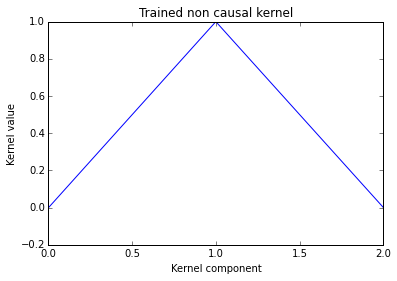

In [11]:
plt.plot(kernel_eval[:,0,0])
plt.title("Trained non causal kernel")
plt.ylabel("Kernel value")
plt.xlabel("Kernel component")
plt.show()